In [1]:
from pyspark.sql.functions import *
import time
import pandas as pd
import matplotlib.pyplot as plt
import builtins
py_sum = builtins.sum
print(f" starting performance experiments")

 starting performance experiments


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("AirbnbPricePredictor") \
    .master("local[*]") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()
print(f" spark session connected")


25/11/26 16:03:21 WARN Utils: Your hostname, MacBook-Pro-110.local resolves to a loopback address: 127.0.0.1; using 10.89.182.38 instead (on interface en0)
25/11/26 16:03:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/26 16:03:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/26 16:03:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


 spark session connected


In [3]:
df = spark.read.parquet("../data/processed/listings_features_no_outliers.parquet")
row_count = df.count()
print(f"dataset: {row_count:,} rows (outliers removed)")

dataset: 108,251 rows (outliers removed)


## Experiment 1: Partitioning Impact on ML Training

This experiment measures how different data partition counts affect Random Forest model training time. Proper partitioning is crucial for distributed ML workloads.


experiment 1: partitioning impact on ml training



training with 4 partitions...
  training time: 1.54s
  rmse: $79.08

training with 8 partitions...


25/11/26 16:03:34 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


  training time: 0.77s
  rmse: $78.97

training with 16 partitions...
  training time: 0.55s
  rmse: $78.87

training with 32 partitions...
  training time: 0.71s
  rmse: $78.91

training with 64 partitions...
  training time: 1.21s
  rmse: $79.00


 partitions  training_time      rmse
          4       1.543141 79.082882
          8       0.771596 78.974049
         16       0.553872 78.866201
         32       0.706277 78.908294
         64       1.212618 79.003382


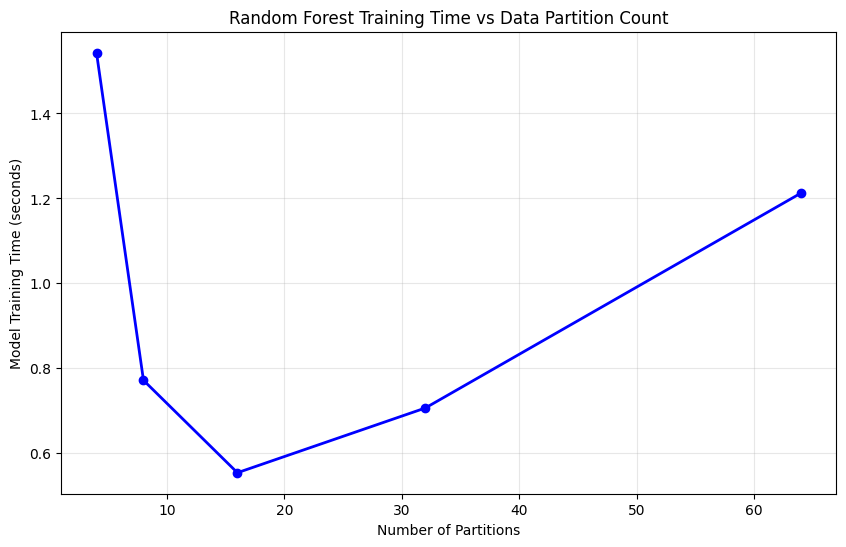

In [ ]:
print(f"=" * 70)
print(f"experiment 1: partitioning impact on ml training")
print(f"=" * 70)

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# prepare ML data
numeric_cols = ["accommodates", "bedrooms", "bathrooms", "latitude", "longitude",
                "minimum_nights", "number_of_reviews", "review_scores_rating"]
df_ml = df.select(numeric_cols + ["price"]).dropna()
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_ml = assembler.transform(df_ml).select("features", "price")

# use a sample for faster experimentation
df_sample = df_ml.sample(0.5, seed=42)
train_base, test_base = df_sample.randomSplit([0.8, 0.2], seed=42)
test_base.cache()
test_base.count()

partition_counts = [4, 8, 16, 32, 64]
results = []

for n_partitions in partition_counts:
    print(f"\ntraining with {n_partitions} partitions...")
    
    # repartition training data
    train_repartitioned = train_base.repartition(n_partitions)
    train_repartitioned.cache()
    train_repartitioned.count()
    
    # train model and measure time
    start = time.time()
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=20,
        maxDepth=5,
        seed=42
    )
    model = rf.fit(train_repartitioned)
    training_time = time.time() - start
    
    # eevaluate model
    predictions = model.transform(test_base)
    evaluator = RegressionEvaluator(labelCol="price", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    
    results.append({
        'partitions': n_partitions,
        'training_time': training_time,
        'rmse': rmse
    })
    print(f"  training time: {training_time:.2f}s")
    print(f"  rmse: ${rmse:.2f}")

    # cleanupp    
    train_repartitioned.unpersist()

results_df = pd.DataFrame(results)
print(f"\n")
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.plot(results_df['partitions'], results_df['training_time'], marker='o', linewidth=2, color='blue')
plt.xlabel('Number of Partitions')
plt.ylabel('Model Training Time (seconds)')
plt.title('Random Forest Training Time vs Data Partition Count')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/figures/partition_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment 2: Caching Impact on ML Training

In [ ]:
print(f"=" * 70)
print(f"experiment 2: caching impact on ml training")
print(f"=" * 70)

# prepare fresh ML data (unpersist any previous caches)
df.unpersist()

numeric_cols = ["accommodates", "bedrooms", "bathrooms", "latitude", "longitude",
                "minimum_nights", "number_of_reviews", "review_scores_rating"]
df_ml_cache = df.select(numeric_cols + ["price"]).dropna()
assembler_cache = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_ml_cache = assembler_cache.transform(df_ml_cache).select("features", "price")

# sample for experiment
df_cache_sample = df_ml_cache.sample(0.4, seed=42)
train_cache, test_cache = df_cache_sample.randomSplit([0.8, 0.2], seed=42)

n_iterations = 3  # simulate hyperparameter tuning with multiple model fits

print(f"\n1. WITHOUT cache (re-reading data each iteration):")
train_cache.unpersist()
times_no_cache = []
for i in range(n_iterations):
    # force re-compu
    train_uncached = train_cache.repartition(8)
    
    start = time.time()
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=15,
        maxDepth=4,
        seed=42 + i
    )
    model = rf.fit(train_uncached)
    elapsed = time.time() - start
    times_no_cache.append(elapsed)
    print(f"   iteration {i+1}: {elapsed:.2f}s")

avg_no_cache = py_sum(times_no_cache) / len(times_no_cache)
total_no_cache = py_sum(times_no_cache)
print(f"   average per model: {avg_no_cache:.2f}s")
print(f"   total time: {total_no_cache:.2f}s")

print(f"\n2. WITH cache (data persisted in memory):")
train_cached = train_cache.repartition(8).cache()
train_cached.count()

times_with_cache = []
for i in range(n_iterations):
    start = time.time()
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=15,
        maxDepth=4,
        seed=42 + i
    )
    model = rf.fit(train_cached)
    elapsed = time.time() - start
    times_with_cache.append(elapsed)
    print(f"   iteration {i+1}: {elapsed:.2f}s")

avg_with_cache = py_sum(times_with_cache) / len(times_with_cache)
total_with_cache = py_sum(times_with_cache)
print(f"   average per model: {avg_with_cache:.2f}s")
print(f"   total time: {total_with_cache:.2f}s")

speedup = avg_no_cache / avg_with_cache if avg_with_cache > 0 else 1.0
total_speedup = total_no_cache / total_with_cache if total_with_cache > 0 else 1.0
print(f"\n speedup: {speedup:.2f}x faster per model with caching")
print(f" total speedup over {n_iterations} iterations: {total_speedup:.2f}x")

cache_comparison = pd.DataFrame({
    'Method': ['No Cache', 'With Cache'],
    'Avg Time (s)': [avg_no_cache, avg_with_cache],
    'Total Time (s)': [total_no_cache, total_with_cache]
})
print(f"\n")
print(cache_comparison.to_string(index=False))

# cleanup
train_cached.unpersist()

experiment 2: caching impact on ml training

1. WITHOUT cache (re-reading data each iteration):
   iteration 1: 0.56s
   iteration 2: 0.50s
   iteration 3: 0.42s
   average per model: 0.49s
   total time: 1.48s

2. WITH cache (data persisted in memory):
   iteration 1: 0.25s
   iteration 2: 0.25s
   iteration 3: 0.24s
   average per model: 0.25s
   total time: 0.74s

 speedup: 2.00x faster per model with caching
 total speedup over 3 iterations: 2.00x


    Method  Avg Time (s)  Total Time (s)
  No Cache      0.494048        1.482145
With Cache      0.247599        0.742796


DataFrame[features: vector, price: float]

## Experiment 3: Model Complexity vs Training Time

experiment 3: model complexity vs training time
training on 26,053 samples

training with 10 trees...
  training time: 0.29s
  rmse: $80.52

training with 30 trees...
  training time: 0.39s
  rmse: $81.30

training with 50 trees...
  training time: 0.65s
  rmse: $80.71

training with 100 trees...
  training time: 1.09s
  rmse: $80.84


 num_trees  training_time      rmse
        10       0.289907 80.523599
        30       0.394951 81.304755
        50       0.652436 80.711125
       100       1.086377 80.837957


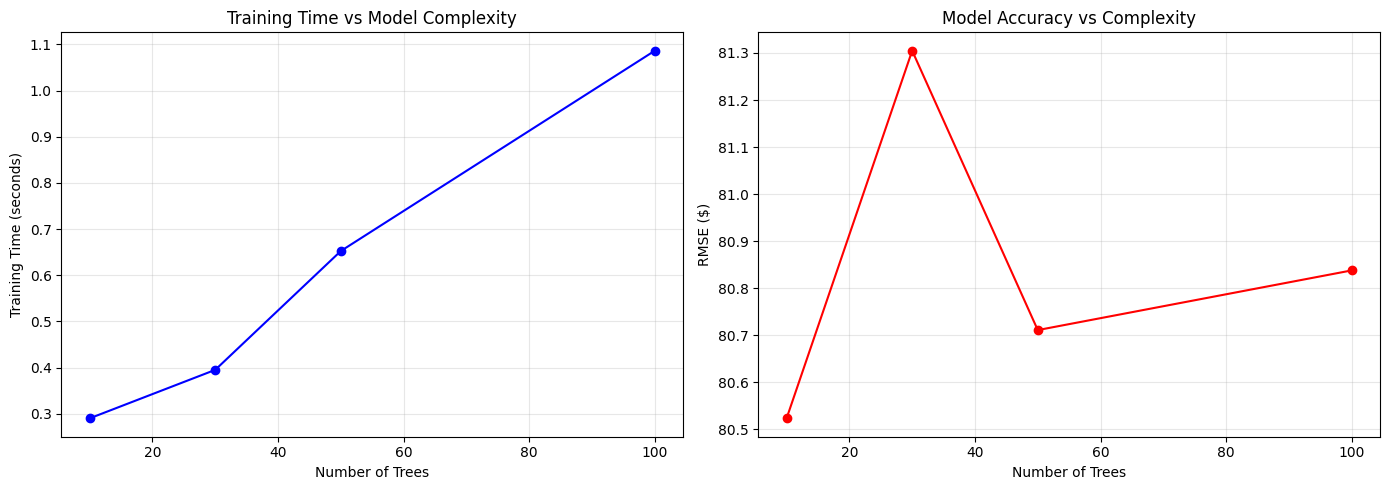

In [6]:
print(f"=" * 70)
print(f"experiment 3: model complexity vs training time")
print(f"=" * 70)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
numeric_cols = ["accommodates", "bedrooms", "bathrooms", "latitude", "longitude"]
df_ml = df.select(numeric_cols + ["price"]).dropna()
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_ml = assembler.transform(df_ml).select("features", "price")
df_sample = df_ml.sample(0.3, seed=42).cache()
train, test = df_sample.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()
print(f"training on {train.count():,} samples")
tree_counts = [10, 30, 50, 100]
model_results = []
for n_trees in tree_counts:
    print(f"\ntraining with {n_trees} trees...")
    start = time.time()
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=n_trees,
        maxDepth=5,
        seed=42
    )
    model = rf.fit(train)
    training_time = time.time() - start
    predictions = model.transform(test)
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol="price", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    model_results.append({
        'num_trees': n_trees,
        'training_time': training_time,
        'rmse': rmse
    })
    print(f"  training time: {training_time:.2f}s")
    print(f"  rmse: ${rmse:.2f}")
model_results_df = pd.DataFrame(model_results)
print(f"\n")
print(model_results_df.to_string(index=False))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(model_results_df['num_trees'], model_results_df['training_time'], marker='o', color='blue')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Training Time (seconds)')
ax1.set_title('Training Time vs Model Complexity')
ax1.grid(True, alpha=0.3)
ax2.plot(model_results_df['num_trees'], model_results_df['rmse'], marker='o', color='red')
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Model Accuracy vs Complexity')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/model_complexity_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Experiment 4: ML Training Scalability

experiment 4: ml training scalability

training with 10% of data...
  training rows: 8,658
  training time: 0.27s
  rmse: $78.54
  throughput: 32,590 rows/sec

training with 25% of data...
  training rows: 21,736
  training time: 0.38s
  rmse: $78.42
  throughput: 57,933 rows/sec

training with 50% of data...
  training rows: 43,273
  training time: 0.74s
  rmse: $78.93
  throughput: 58,101 rows/sec

training with 75% of data...
  training rows: 64,837
  training time: 0.52s
  rmse: $79.46
  throughput: 124,818 rows/sec

training with 100% of data...
  training rows: 86,203
  training time: 0.59s
  rmse: $78.21
  throughput: 146,309 rows/sec


 fraction  train_rows  training_time      rmse  rows_per_second
     0.10        8658       0.265667 78.543877     32589.645982
     0.25       21736       0.375190 78.420249     57933.310760
     0.50       43273       0.744787 78.928008     58101.158371
     0.75       64837       0.519454 79.463920    124817.596366
     1.00       86203       

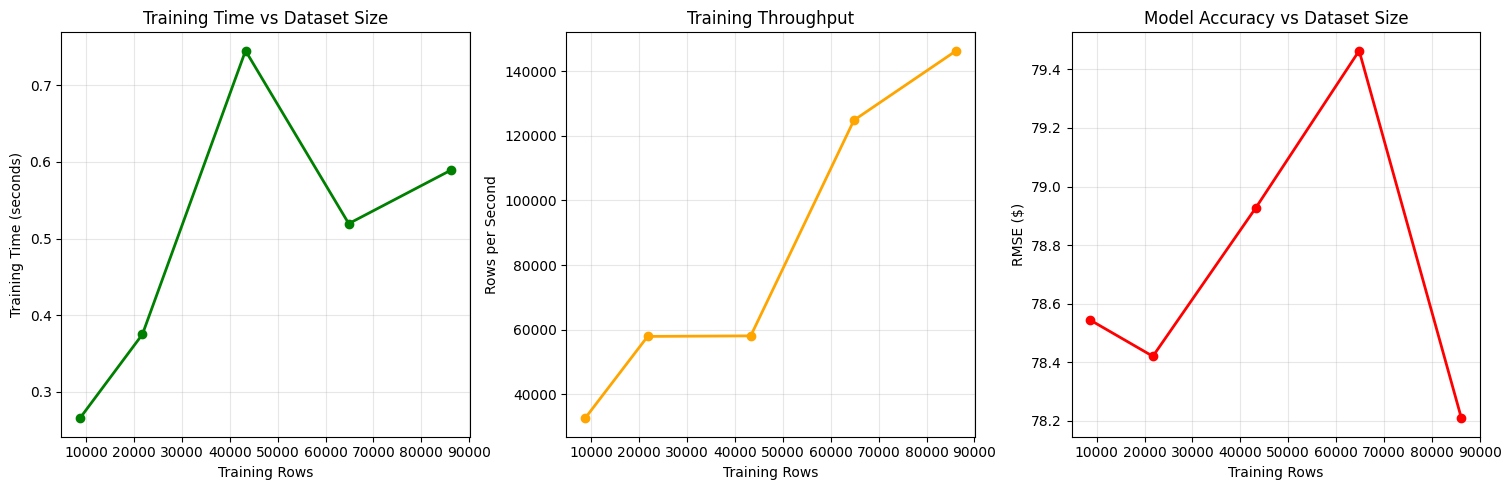

In [ ]:
print(f"=" * 70)
print(f"experiment 4: ml training scalability")
print(f"=" * 70)

numeric_cols = ["accommodates", "bedrooms", "bathrooms", "latitude", "longitude",
                "minimum_nights", "number_of_reviews", "review_scores_rating"]
df_ml_scale = df.select(numeric_cols + ["price"]).dropna()
assembler_scale = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_ml_scale = assembler_scale.transform(df_ml_scale).select("features", "price")

fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
scaling_results = []

for frac in fractions:
    print(f"\ntraining with {frac*100:.0f}% of data...")
    
    # sample data 
    df_frac = df_ml_scale.sample(frac, seed=42)
    train_frac, test_frac = df_frac.randomSplit([0.8, 0.2], seed=42)
    
    # cache for fair comparison
    train_frac.cache()
    test_frac.cache()
    train_count = train_frac.count()
    test_frac.count()
    
    # train model
    start = time.time()
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=20,
        maxDepth=5,
        seed=42
    )
    model = rf.fit(train_frac)
    training_time = time.time() - start
    
    # evals
    predictions = model.transform(test_frac)
    evaluator = RegressionEvaluator(labelCol="price", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    
    scaling_results.append({
        'fraction': frac,
        'train_rows': train_count,
        'training_time': training_time,
        'rmse': rmse,
        'rows_per_second': train_count / training_time
    })
    print(f"  training rows: {train_count:,}")
    print(f"  training time: {training_time:.2f}s")
    print(f"  rmse: ${rmse:.2f}")
    print(f"  throughput: {train_count/training_time:,.0f} rows/sec")
    
    # cleanup
    train_frac.unpersist()
    test_frac.unpersist()

scaling_df = pd.DataFrame(scaling_results)
print(f"\n")
print(scaling_df.to_string(index=False))

# plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# training time vs dataset size
axes[0].plot(scaling_df['train_rows'], scaling_df['training_time'], marker='o', color='green', linewidth=2)
axes[0].set_xlabel('Training Rows')
axes[0].set_ylabel('Training Time (seconds)')
axes[0].set_title('Training Time vs Dataset Size')
axes[0].grid(True, alpha=0.3)

# throughput
axes[1].plot(scaling_df['train_rows'], scaling_df['rows_per_second'], marker='o', color='orange', linewidth=2)
axes[1].set_xlabel('Training Rows')
axes[1].set_ylabel('Rows per Second')
axes[1].set_title('Training Throughput')
axes[1].grid(True, alpha=0.3)

# rmse vs dataset size
axes[2].plot(scaling_df['train_rows'], scaling_df['rmse'], marker='o', color='red', linewidth=2)
axes[2].set_xlabel('Training Rows')
axes[2].set_ylabel('RMSE ($)')
axes[2].set_title('Model Accuracy vs Dataset Size')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/dataset_size_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

## Performance Summary

In [8]:
print(f"=" * 70)
print(f"performance experiment summary")
print(f"=" * 70)

print(f"\n1. partitioning impact on ml training:")
optimal_partitions = results_df.loc[results_df['training_time'].idxmin(), 'partitions']
best_partition_time = results_df.loc[results_df['training_time'].idxmin(), 'training_time']
worst_partition_time = results_df['training_time'].max()
print(f"   optimal partition count: {optimal_partitions}")
print(f"   best training time: {best_partition_time:.2f}s")
print(f"   worst training time: {worst_partition_time:.2f}s")
print(f"   improvement: {((worst_partition_time - best_partition_time) / worst_partition_time * 100):.1f}%")

print(f"\n2. caching impact on ml training:")
print(f"   speedup per model: {speedup:.2f}x")
print(f"   total speedup ({n_iterations} iterations): {total_speedup:.2f}x")

print(f"\n3. model complexity trade-off:")
best_model = model_results_df.loc[model_results_df['rmse'].idxmin()]
print(f"   best accuracy: {int(best_model['num_trees'])} trees (rmse: ${best_model['rmse']:.2f})")
print(f"   training time: {best_model['training_time']:.2f}s")

print(f"\n4. ml training scalability:")
avg_throughput = scaling_df['rows_per_second'].mean()
best_rmse = scaling_df['rmse'].min()
print(f"   average training throughput: {avg_throughput:,.0f} rows/second")
print(f"   best rmse (full data): ${best_rmse:.2f}")

print(f"\n" + "=" * 70)
print(f"all performance experiments complete")
print(f"=" * 70)

performance experiment summary

1. partitioning impact on ml training:
   optimal partition count: 16
   best training time: 0.55s
   worst training time: 1.54s
   improvement: 64.1%

2. caching impact on ml training:
   speedup per model: 2.00x
   total speedup (3 iterations): 2.00x

3. model complexity trade-off:
   best accuracy: 10 trees (rmse: $80.52)
   training time: 0.29s

4. ml training scalability:
   average training throughput: 83,950 rows/second
   best rmse (full data): $78.21

 all performance experiments complete
